In [1]:
import time
from coffea import hist, nanoevents, util
import coffea.processor as processor
import awkward as ak
import numpy as np
import glob as glob
import re
import itertools
# import vector as vec
from coffea.nanoevents.methods import vector, candidate
from coffea.nanoevents import NanoAODSchema, BaseSchema
from coffea.lumi_tools import LumiMask
# for applying JECs
from coffea.lookup_tools import extractor
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty
from coffea.jetmet_tools import JECStack, CorrectedJetsFactory
from coffea.jetmet_tools import JetResolution, JetResolutionScaleFactor
# from jmeCorrections import JetMetCorrections
import json


import coffea.processor as processor
from coffea import hist
from coffea.analysis_tools import PackedSelection, Weights
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory
from coffea.nanoevents.methods import nanoaod

# NanoAODSchema.warn_missing_crossrefs = False

import pickle
# np.errstate(invalid='ignore', divide='ignore')



import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from coffea.util import load, save
#hists = load('/cms/scratch/sdogra/mtop/rishabh/decaf/analysis/hists/UL_had_full_2018.scaled')
#hists = load('/cms/scratch/sdogra/mtop/rishabh/decaf/analysis/hists/UL_had_ttag_cutflow_2018.scaled')
#hists = load('/cms/scratch/sdogra/mtop/rishabh/decaf/analysis/hists/UL_had_ttag_cutflow_2018_v2.scaled')
hists = load('/cms/scratch/sdogra/mtop/rishabh/decaf/analysis/hists/UL_had_ttag_cutflow_2018_v3.scaled')
# _v3: MET
#hists = load('/cms/scratch/sdogra/mtop/rishabh/decaf/analysis/hists/UL_had_test_2018_x.scaled')

data_hists = hists['data']
bkg_hists = hists['bkg']
sig_hists = hists['sig']

In [11]:
bkg_hists

{'template': <Hist (process,region,systematic,recoil) instance at 0x7f6bbff69908>,
 'ele_phi': <Hist (process,region,ele_phi) instance at 0x7f6bbff1ecc0>,
 'sumw': <Hist (process,sumw) instance at 0x7f6bbff2f0f0>,
 'j1pt': <Hist (process,region,j1pt) instance at 0x7f6bbff2f3c8>,
 'leading_qWmatchedJet': <Hist (process,region,tag,leading_qWmatchedJet) instance at 0x7f6bbff2f780>,
 'metphi': <Hist (process,region,metphi) instance at 0x7f6bbff2fc88>,
 'ndflvM': <Hist (process,region,ndflvM) instance at 0x7f6bbff340f0>,
 'dr_mu_lj': <Hist (process,region,dr_mu_lj) instance at 0x7f6bbff344a8>,
 'ele_pT': <Hist (process,region,ele_pT) instance at 0x7f6bbff34860>,
 'mu_eta': <Hist (process,region,mu_eta) instance at 0x7f6bbff34c50>,
 'recoil_sr': <Hist (process,region,recoil_sr) instance at 0x7f6bbff36048>,
 'TvsQCD': <Hist (process,region,TvsQCD) instance at 0x7f6bbff36400>,
 'j1phi': <Hist (process,region,j1phi) instance at 0x7f6bbff367f0>,
 'nfatjets': <Hist (process,region,nfatjets) insta

In [12]:
sig_hists

{'template': <Hist (process,region,systematic,recoil) instance at 0x7f6bbfed5898>,
 'ele_phi': <Hist (process,region,ele_phi) instance at 0x7f6bbfed58d0>,
 'sumw': <Hist (process,sumw) instance at 0x7f6bbfed5940>,
 'j1pt': <Hist (process,region,j1pt) instance at 0x7f6bbfed59b0>,
 'leading_qWmatchedJet': <Hist (process,region,tag,leading_qWmatchedJet) instance at 0x7f6bbfed5a20>,
 'metphi': <Hist (process,region,metphi) instance at 0x7f6bbfed5a90>,
 'ndflvM': <Hist (process,region,ndflvM) instance at 0x7f6bbfed5b00>,
 'dr_mu_lj': <Hist (process,region,dr_mu_lj) instance at 0x7f6bbfed5b70>,
 'ele_pT': <Hist (process,region,ele_pT) instance at 0x7f6bbfed5be0>,
 'mu_eta': <Hist (process,region,mu_eta) instance at 0x7f6bbfed5c50>,
 'recoil_sr': <Hist (process,region,recoil_sr) instance at 0x7f6bbfed5cc0>,
 'TvsQCD': <Hist (process,region,TvsQCD) instance at 0x7f6bbfed5d30>,
 'j1phi': <Hist (process,region,j1phi) instance at 0x7f6bbfed5da0>,
 'nfatjets': <Hist (process,region,nfatjets) insta

In [3]:
vari = 'cutflow' # 'cutflow'  # 'drfjtop' #'fj1pt' # 'leading_tvsqcd' # 'leading_qWmatchedJet'
region = 'tmcr'

In [4]:
sig_hists[vari]#.identifiers('process')

<Hist (process,region,cut) instance at 0x7efce320e2b0>

In [15]:
sig_hists[vari].identifiers('cut')

[<Interval ([0, 1)) instance at 0x7f6bbff90f28>,
 <Interval ([1, 2)) instance at 0x7f6bbff90eb8>,
 <Interval ([2, 3)) instance at 0x7f6bbff90e48>,
 <Interval ([3, 4)) instance at 0x7f6bbff90dd8>,
 <Interval ([4, 5)) instance at 0x7f6bbff90d68>,
 <Interval ([5, 6)) instance at 0x7f6bbff90cf8>,
 <Interval ([6, 7)) instance at 0x7f6bbff90c88>,
 <Interval ([7, 8)) instance at 0x7f6bbff90c18>,
 <Interval ([8, 9)) instance at 0x7f6bbff90ba8>,
 <Interval ([9, 10)) instance at 0x7f6bbff90b38>,
 <Interval ([10, 11)) instance at 0x7f6bbff90ac8>,
 <Interval ([11, 12)) instance at 0x7f6bbff90a58>,
 <Interval ([12, 13)) instance at 0x7f6bbff909e8>,
 <Interval ([13, 14)) instance at 0x7f6bbff90978>,
 <Interval ([14, 15)) instance at 0x7f6bbff897f0>,
 <Interval ([15, 16)) instance at 0x7f6bbff666d8>,
 <Interval ([16, 17)) instance at 0x7f6bbff660b8>]

In [6]:
data_hists[vari].integrate('process').integrate('region').values()

{(): array([1.17518e+05, 5.02660e+04, 3.02940e+04, 1.48980e+04, 1.48980e+04,
        1.27400e+03, 2.54000e+02, 6.80000e+01, 6.80000e+01, 5.90000e+01,
        1.80000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00])}

In [3]:
vari = 'cutflow' # 'cutflow'  # 'drfjtop' #'fj1pt' # 'leading_tvsqcd' # 'leading_qWmatchedJet'
region = 'tmcr'
#sig_hists[vari].integrate('region',region).integrate('tag','pass').sum(vari).values()
#sig_hists[vari].integrate('region',region).values()
##bkg_hists[vari].integrate('region',region).values()
data_hists[vari].integrate('region',region).values()

{('MET',): array([1.17518e+05, 5.02660e+04, 3.02940e+04, 1.48980e+04, 1.48980e+04,
        1.34200e+03, 2.78000e+02, 7.80000e+01, 7.80000e+01, 6.80000e+01,
        1.90000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00])}

In [43]:
vari = 'leading_qWmatchedJet' # 'cutflow'  # 'drfjtop' #'fj1pt' # 'leading_tvsqcd' # 'leading_qWmatchedJet'
region = 'tmcr'
#print('pass:', sig_hists[vari].integrate('region',region).integrate('tag','pass').sum(vari).values())
#print('fail:', sig_hists[vari].integrate('region',region).integrate('tag','fail').sum(vari).values())
print('pass:', bkg_hists[vari].integrate('region',region).integrate('tag','pass').sum(vari).values())
print('fail:', bkg_hists[vari].integrate('region',region).integrate('tag','fail').sum(vari).values())

pass: {('TT',): 67.1464976149}
fail: {('TT',): 23870.579902096943}


In [44]:
cut_bin = None
exp = 0
#vari = 'fj1pt'
#region = 'sr'
print('======= ',region, '=======')
print('variable ', vari)
print('=====================')
for p in bkg_hists[vari].identifiers('process'):
    #print(p)
    #yld_array = sig_hists[vari].integrate('region',region).integrate('process', p).integrate('tag','pass').sum().values(overflow='all')
    yld_array = bkg_hists[vari].integrate('region',region).integrate('process', p).integrate('tag','pass').sum().values(overflow='all')
    if () in yld_array:
        print('() in yld_array')
        #yld = np.cumsum(yld_array[()])[nbins-1]
        yld = yld_array[()].sum()
        if cut_bin!=None: yld = yld - np.cumsum(yld_array[()])[cut_bin]
        #if cut_bin!=None: yld = np.cumsum(yld_array[()])[cut_bin]
        exp += yld
        print(p, '%.1f' % yld)
#print(bkg_hists[vari].identifiers('process'))
#sig_hists[vari].integrate('region',region).integrate('process').integrate('tag','pass').sum('qWmatchedJet').values()[()]
bkg_hists[vari].integrate('region',region).integrate('process').integrate('tag','pass').sum(vari).values()[()]

=======  tmcr =======
variable  leading_qWmatchedJet
() in yld_array
TT 70.2


67.1464976149

In [22]:
#sig_hists[vari].identifiers('process')
bkg_hists[vari].identifiers('process')

[<StringBin (TT) instance at 0x7f35eb26c240>]

In [24]:
#sig_hists[vari].integrate('process').integrate('region',region).sum('qWmatchedJet').values()
bkg_hists[vari].integrate('process').integrate('region',region).sum(vari).values()

{('pass',): 67.1464976149, ('fail',): 23870.579902096943}

(0.1, 100000)

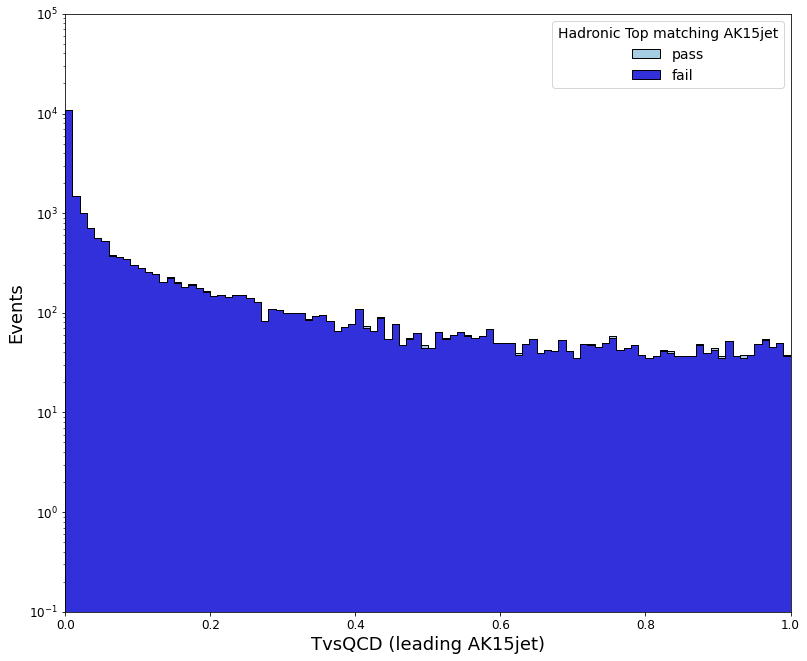

In [45]:
from coffea.hist import plot
from cycler import cycler
vari = 'leading_qWmatchedJet'

plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
fig, ax = plt.subplots(figsize=(13,11))
fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
colors = ['#a6cee3', '#3130db', '#1f78b4', '#b2df8a', '#48e926', '#33a02c', '#c0df26',
          '#fb9a99', '#d02ba7', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#c64bc4',
          '#6a3d9a', '#a9ce26', '#ffff99', '#b15928', '#edcc43']
ax.set_prop_cycle(cycler(color=colors))
plot.plot1d(bkg_hists[vari].integrate('region',region).integrate('process'),overlay="tag", stack=True,clear=False, fill_opts=fill_opts, ax=ax)
#plot.plot1d(sig_hists[vari].integrate('region',region).integrate('process'),overlay="tag", stack=True,clear=False, fill_opts=fill_opts, ax=ax)
#plot.plot1d(sig_hists[vari].integrate('region',region).integrate('process').integrate('tag'), stack=True,clear=False, fill_opts=fill_opts, ax=ax)



#coffee = plt.text(0., 1., u"☕ W(m) CR", fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
args = {'linestyle':'--', 'linewidth': 5}
ax.set_yscale('log')
#ax.set_ylim(.0000001, 10)
ax.set_ylim(0.1, 100000)
#ax.set_xlim(0, 1300)

([<matplotlib.axis.XTick at 0x7fd8f30c7ba8>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

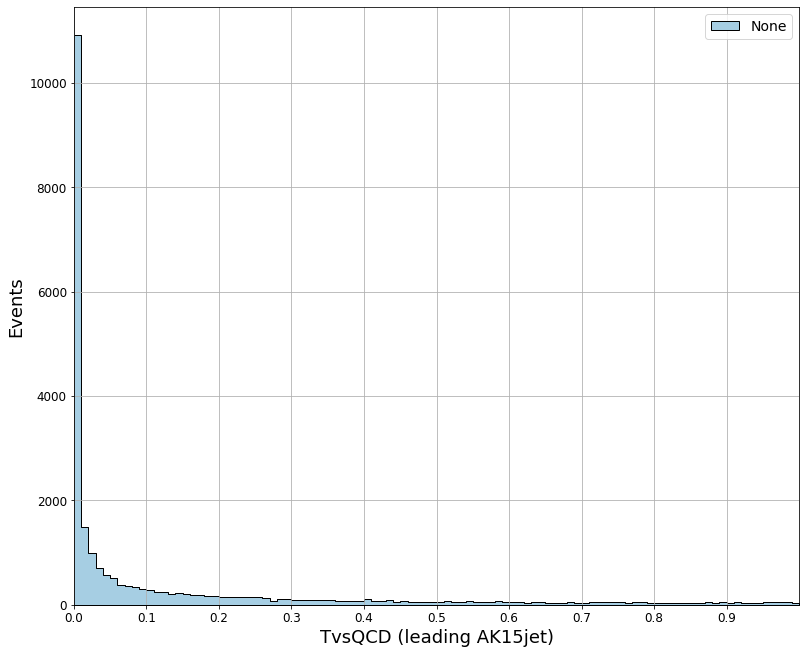

In [13]:
#########
# scale (tag)
#########
from coffea.hist import plot
from cycler import cycler

vari = "leading_qWmatchedJet"


#vari_ = "qWmatchedJet"
fname = "TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8" # "Mphi-1700_Mchi-800"

plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
fig, ax = plt.subplots(figsize=(13,11))
fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
colors = ['#a6cee3', '#3130db', '#1f78b4', '#b2df8a', '#48e926', '#33a02c', '#c0df26',
          '#fb9a99', '#d02ba7', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#c64bc4',
          '#6a3d9a', '#a9ce26', '#ffff99', '#b15928', '#edcc43']
ax.set_prop_cycle(cycler(color=colors))
tot = {}
tot[fname] = bkg_hists[vari].integrate('process').integrate('region').integrate('tag').sum(vari).values()[()]
#tot[fname] = sig_hists[vari].integrate('process').integrate('region').sum(vari).values()[()]
bkg_hists[vari].scale({fname:1/tot[fname]},axis='process')

##sig_hists[vari].scale({fname:1/tot[fname]},axis='process')
#sig_hists[vari].integrate('region',region).rebin(vari_,5)
#sig_hists[vari].integrate('region',region).rebin(vari,2)
plot.plot1d(bkg_hists[vari].integrate('region',region).integrate('process').integrate('tag'), stack=True,clear=False, fill_opts=fill_opts, ax=ax)
#plot.plot1d(sig_hists[vari].integrate('region',region).integrate('process'),overlay="tag", stack=True,clear=False, fill_opts=fill_opts, ax=ax)
#plot.plot1d(sig_hists[vari].integrate('region',region).integrate('tag').rebin(vari_,2),overlay='process', stack=True,clear=False, fill_opts=fill_opts,  ax=ax)



#coffee = plt.text(0., 1., u"☕ W(m) CR", fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
args = {'linestyle':'--', 'linewidth': 5}
plt.grid(True)
#ax.set_yscale('log')
#ax.set_ylim(.00001, 10)
#ax.set_ylim(.1, 100000)
plt.xticks(np.arange(0,1,0.1))
#ax.set_xlim(0, 1300)

([<matplotlib.axis.XTick at 0x7fd8f29f4b00>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

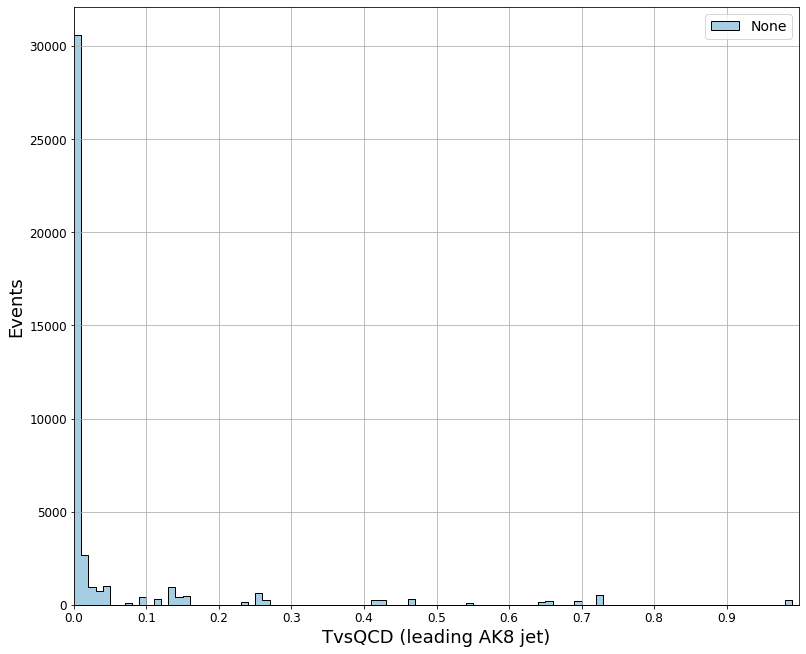

In [20]:
#########
# scale one variable
#########
from coffea.hist import plot
from cycler import cycler

#vari = "ak8_tvsqcd"
vari = "ak8_tvsqcd"

#vari_ = "qWmatchedJet"
fname = "Mphi-1700_Mchi-800"

plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
fig, ax = plt.subplots(figsize=(13,11))
fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
colors = ['#a6cee3', '#3130db', '#1f78b4', '#b2df8a', '#48e926', '#33a02c', '#c0df26',
          '#fb9a99', '#d02ba7', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#c64bc4',
          '#6a3d9a', '#a9ce26', '#ffff99', '#b15928', '#edcc43']
ax.set_prop_cycle(cycler(color=colors))
tot = {}
##tot[fname] = sig_hists[vari].integrate('process').integrate('region').sum(vari).values()[()]
tot[fname] = bkg_hists[vari].integrate('process').integrate('region').sum(vari).values()[()]

#tot[fname] = sig_hists[vari].integrate('process').integrate('region').sum(vari).values()[()]
##sig_hists[vari].scale({fname:1/tot[fname]},axis='process')
bkg_hists[vari].scale({fname:1/tot[fname]},axis='process')
#sig_hists[vari].integrate('region',region).rebin(vari_,5)
#sig_hists[vari].integrate('region',region).rebin(vari,2)
#plot.plot1d(sig_hists[vari].integrate('region',region).integrate('process'), stack=True,clear=False, fill_opts=fill_opts, ax=ax)
##plot.plot1d(sig_hists[vari].integrate('region',region).integrate('process'), stack=True,clear=False, fill_opts=fill_opts, ax=ax)
plot.plot1d(bkg_hists[vari].integrate('region',region).integrate('process'), stack=True,clear=False, fill_opts=fill_opts, ax=ax)

#plot.plot1d(sig_hists[vari].integrate('region',region).integrate('tag').rebin(vari_,2),overlay='process', stack=True,clear=False, fill_opts=fill_opts,  ax=ax)



#coffee = plt.text(0., 1., u"☕ W(m) CR", fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
args = {'linestyle':'--', 'linewidth': 5}
plt.grid(True)
#ax.set_yscale('log')
#ax.set_ylim(.00001, 10)
ax.set_xlabel("TvsQCD (leading AK8 jet)")
plt.xticks(np.arange(0,1,0.1))
#ax.set_xlim(0, 1300)

<Hist (ak8_leading_qWmatchedJet) instance at 0x7f7f36007048>
<Hist (ak8_leading_qWmatchedJet) instance at 0x7f7f36007320>
sum_bins_arr:  [32483. 17697. 16210. 15238. 14563. 13984. 13547. 13164. 12793. 12501.
 12224. 11975. 11758. 11526. 11315. 11121. 10952. 10789. 10621. 10470.
 10323. 10197. 10063.  9947.  9833.  9727.  9634.  9527.  9437.  9332.
  9250.  9135.  9057.  8968.  8885.  8790.  8703.  8622.  8529.  8457.
  8381.  8301.  8227.  8149.  8065.  8003.  7915.  7844.  7779.  7723.
  7645.  7578.  7519.  7459.  7405.  7330.  7265.  7200.  7145.  7096.
  7039.  6981.  6921.  6856.  6803.  6734.  6663.  6601.  6541.  6485.
  6419.  6351.  6276.  6197.  6139.  6070.  5996.  5930.  5859.  5806.
  5738.  5665.  5579.  5506.  5437.  5357.  5256.  5157.  5050.  4950.
  4848.  4719.  4582.  4473.  4325.  4158.  3942.  3709.  3382.  2873.]
tot[fname]:  32483.0


([<matplotlib.axis.YTick at 0x7f7f35fc1ef0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

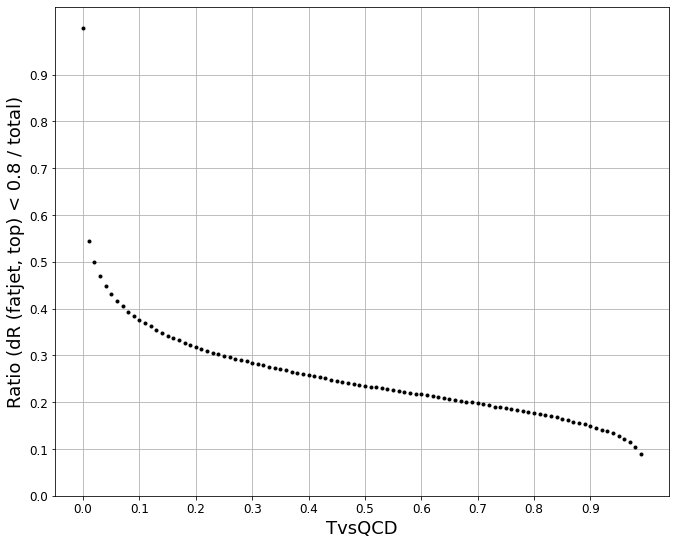

In [14]:
# nume/deno
from coffea.hist import plot

vari = "ak8_leading_qWmatchedJet" # "leading_qWmatchedJet"
vari_ = "ak8_leading_qWmatchedJet" # "qWmatchedJet"
fname =  "Mphi-1700_Mchi-800"

denominator = sig_hists[vari].integrate('process').integrate('region','sr').integrate('tag')
numerator   = sig_hists[vari].integrate('process').integrate('region','sr').integrate('tag','pass')

print(denominator)
print(numerator)

sum_bins = list()
for n in range(len(denominator.values()[()])):
    sum_bins.append(denominator.values()[()][n:].sum())
    
sum_bins_arr = np.array(sum_bins)
print('sum_bins_arr: ',sum_bins_arr)

numerator_sum = hist.Hist(
    'Events',
    hist.Cat('dataset', 'Dataset'),
    hist.Bin('nume_sum', 'TvsQCD', 100, sum_bins_arr.min(),sum_bins_arr.max())
)
numerator_sum.fill(dataset = fname, nume_sum=sum_bins_arr)

tot = {}
tot[fname] = sig_hists[vari].integrate('process').integrate('region','sr').integrate('tag').sum(vari_).values()[()]
print('tot[fname]: ', tot[fname])

hhh = sum_bins_arr/tot[fname]
ggg = np.arange(0,1,0.01)

plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize':(11,9)})
plt.grid(True)

plt.ylabel('Ratio (dR (fatjet, top) < 0.8 / total)')
plt.xlabel('TvsQCD')

plt.plot(ggg,hhh,'k.')
#plt.plot(hhh,'k.')

plt.xticks(np.arange(0,1,0.1))
plt.yticks(np.arange(0,1,0.1))



<AxesSubplot:xlabel='AK15 Leading Jet Pt', ylabel='Events'>

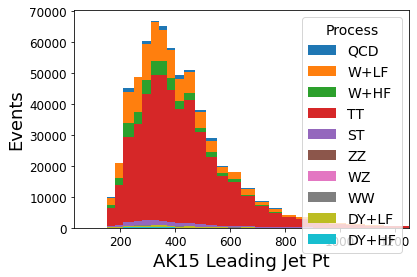

In [19]:
from coffea.hist import plot

plot.plot1d(bkg_hists[vari].integrate('region',region), stack=True)


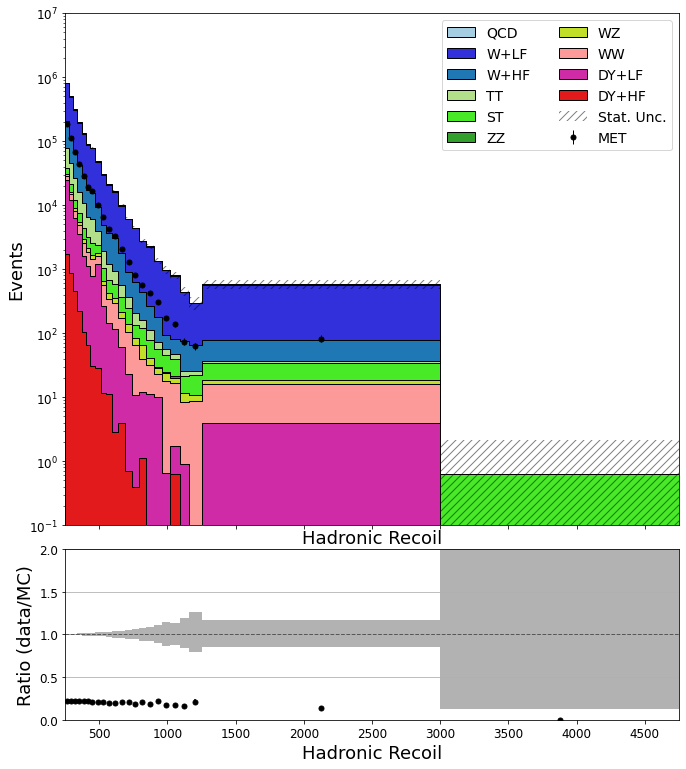

In [21]:
from cycler import cycler
from coffea.hist import plot

vari = 'recoil'
#vari = 'mu_pT'
region = 'wmcr'
if 'e' in region:
    data = 'EGamma'
else:
    data = 'MET'
#data = 'EGamma' 
#data = 'MET' 
#data = 'MET'

plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
colors = ['#a6cee3', '#3130db', '#1f78b4', '#b2df8a', '#48e926', '#33a02c', '#c0df26',
          '#fb9a99', '#d02ba7', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#c64bc4',
          '#6a3d9a', '#a9ce26', '#ffff99', '#b15928', '#edcc43']
fig, (ax, rax) = plt.subplots(2, 1, figsize=(11,13), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)
ax.set_prop_cycle(cycler(color=colors))

plot.plot1d(data_hists[vari].integrate('region', region),#[data[year][str(j)]],
            overlay="process",
            ax=ax,
            overflow='over',
            clear=False,
            error_opts=data_err_opts
           )

plot.plot1d(bkg_hists[vari].integrate('region', region),
            overlay="process",
            ax=ax,
            overflow='over',
            clear=False,
            stack=True,
            fill_opts=fill_opts,
            error_opts=error_opts
           )

plot.plotratio(data_hists[vari].integrate('region', region).integrate('process', data),
               bkg_hists[vari].integrate('region', region).sum('process'),
               ax=rax,
               overflow='over',
               error_opts=data_err_opts,
               denom_fill_opts={},
               guide_opts={},
               unc='num'
              )

rax.set_ylabel('Ratio (data/MC)')
rax.set_ylim(0.0,2.0)
rax.grid(axis='y')

ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
args = {'linestyle':'--', 'linewidth': 5}
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylim(.1, 10000000)
#ax.set_xlim(0, 300)
leg = ax.legend(ncol=2, loc='best')

In [16]:
sig_hists[vari].identifiers('region')

[<StringBin (sr) instance at 0x7f81b876d9e8>]

In [17]:
for region in sig_hists[vari].identifiers('region'):
    print(region)
sig_hists[vari].integrate('process').integrate('region','sr').values()

sr


{(): array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])}

<AxesSubplot:xlabel='Hadronic Recoil', ylabel='Events'>

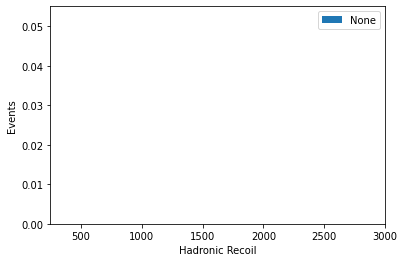

In [18]:
plot.plot1d(sig_hists[vari].integrate('process').integrate('region','sr'), stack=True)


In [63]:
data_hists[vari].identifiers('process')

[<StringBin (MET) instance at 0x7f7b6087b400>,
 <StringBin (EGamma) instance at 0x7f7b6087b518>]

In [64]:
data_hists[vari].integrate('region',region).values()

{('EGamma',): array([   0.,    0.,    0.,    0., 1427., 2954., 6198., 6530., 7829.,
        8294., 7627., 6752., 5607., 5830., 4318., 3156., 2375., 2008.,
        1345.,  916.,  613.,  488.,  375.,  266.,  187.,  115.,   98.,
          67.])}

<AxesSubplot:xlabel='AK15 Leading Jet Pt', ylabel='Events'>

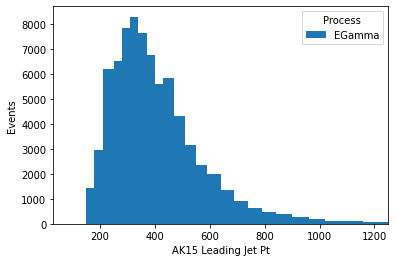

In [65]:
plot.plot1d(data_hists[vari].integrate('region',region), stack=True)


In [23]:
bkg_hists['sumw'].identifiers('process')#.identifiers('sumw')

[<StringBin (DY+HF) instance at 0x7f2a4100dbe0>,
 <StringBin (DY+LF) instance at 0x7f2a4100dc88>,
 <StringBin (WW) instance at 0x7f2a4100d978>,
 <StringBin (WZ) instance at 0x7f2a4100dcf8>,
 <StringBin (ZZ) instance at 0x7f2a4100d908>,
 <StringBin (ST) instance at 0x7f296f940358>,
 <StringBin (TT) instance at 0x7f296f8d7da0>,
 <StringBin (W+HF) instance at 0x7f296f8d7e10>,
 <StringBin (W+LF) instance at 0x7f296f8d7e48>,
 <StringBin (QCD) instance at 0x7f296f9032e8>]